In [61]:
import os
from PIL import Image
import glob
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import *
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from matplotlib.pyplot import imshow
from tensorflow.keras.preprocessing.image import *
from matplotlib import pyplot as plt

<h5> Photos are uploaded from a folder which contains all the photos from UTKFace Dataset 
    <br>
    </h5> 
    <p>Link of the dataset: <a href =  https://susanqq.github.io/UTKFace/> 
     https://susanqq.github.io/UTK
<a/>
</p>
<p> Age is extracted from the filename of the image. </p>



In [166]:
image_list = []
img_age = []

for filename in glob.glob('UTKFace/*.jpg'):  
    filename = str(filename)
    img_age.append(filename[filename.find("\\")+1:filename.find("_")])
    im=Image.open(filename)
    im = im.resize((50,50))
    image_list.append(np.asarray(im))


data = np.array(image_list)

labels = np.array(img_age).astype(np.float)

<h5> It can be seen that data is not equally distributed, Nearly 10% of the data consists from 26 year olds. </h5>

In [167]:
df = pd.DataFrame(labels, columns = ["Age"])

df["Age"].value_counts().head(10)

26.0    2197
1.0     1123
28.0     918
35.0     880
24.0     859
25.0     734
30.0     724
32.0     664
27.0     615
29.0     570
Name: Age, dtype: int64

<h5> Visualizing the distribution of data: </h5>

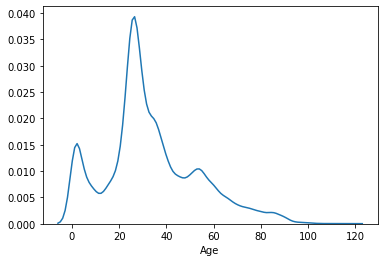

In [172]:
sns.distplot(df["Age"], hist = False)

<h5>To better understand the distribution, we make a quantile based binning of the ages.</h5>

In [175]:
df["bins"] = pd.qcut(df["Age"], 10)

df.groupby("bins").count()

,Age
bins,
"(0.999, 6.0]",2494
"(6.0, 20.0]",2383
"(20.0, 25.0]",2760
"(25.0, 26.0]",2197
"(26.0, 29.0]",2103
"(29.0, 34.0]",2290
"(34.0, 40.0]",2773
"(40.0, 50.0]",2100
"(50.0, 61.0]",2372


<h5>Binning the data into age groups. 
<br>
<br>    
I did this binning considering the distribution of the data, but I also wanted every class to be similar and logical in itself.

</h5>

In [176]:
i = 0

while i < len(labels):
    if labels[i] >= 0 and labels[i] < 4:
        labels[i] = 0
    elif labels[i] >= 4 and labels[i] < 13:
        labels[i] = 1
    elif labels[i] >= 13 and labels[i] < 21:
        labels[i] = 2
    elif labels[i] >= 21 and labels[i] < 31:
        labels[i] = 3
    elif labels[i] >= 31 and labels[i] < 46:
        labels[i] = 4
    elif labels[i] >= 46 and labels[i] < 65:
        labels[i] = 5
    elif labels[i] >= 65:
        labels[i] = 6
    i += 1
    
age_dict = {
    0:"0-3",
    1:"4-12",
    2:"13-20",
    3:"21-30",
    4:"31-45",
    5:"46-64",
    6:"65+",

}

<h5>Size of the classes: </h5>

In [190]:
pd.Series(labels).value_counts().sort_index()

0.0    1894
1.0    1519
2.0    1464
3.0    7784
4.0    5434
5.0    3655
6.0    1958
dtype: int64

<h5>Splitting the data: </h5>

In [193]:
X_train, X_val, y_train, y_val = train_test_split(data, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5)

In [196]:
print(X_train.shape)

(18966, 50, 50, 3)


<h5>There aren't too many images, so I used the Data Generator class of Keras for Data Augmentation.
<br>
    <br>
I only inserted newly created images to training set, not to the validation or test sets.</h5>

In [32]:
datagen = ImageDataGenerator()

datagen.fit(X_train)
X_batch = datagen.flow(X_train, y_train, batch_size=32)

X_aug = []
y_aug = []

for i in range(0,len(X_batch)):
    batch = X_batch[i]
    for elem in batch[:][0]:
        X_aug.append(elem)
    for elem in batch[:][1]:
        y_aug.append(elem)
        
X_aug = np.array(X_aug)        
y_aug = np.array(y_aug)

X_train = np.append(X_train, X_aug, axis = 0)
y_train = np.append(y_train, y_aug, axis = 0)

<h5>Model</h5>

In [197]:
num_filters = 32
filter_size = 3
pool_size = 2

# Build the model.
model = Sequential([
  Conv2D(num_filters, filter_size, input_shape=data.shape[1:], activation = "relu"),
  BatchNormalization(),
  MaxPooling2D(pool_size=pool_size),
  Conv2D(num_filters, 3, input_shape=data.shape[1:], activation = "relu"),
  BatchNormalization(),
  MaxPooling2D(pool_size=pool_size),
  Conv2D(num_filters, 3, input_shape=data.shape[1:], activation = "relu"),
  BatchNormalization(),
  MaxPooling2D(pool_size=pool_size),
  Dropout(0.3),
  Conv2D(num_filters, 3, input_shape=data.shape[1:], activation = "relu"),
  BatchNormalization(),
  MaxPooling2D(pool_size=pool_size),
  Dropout(0.3),
  Conv2D(num_filters, 1, input_shape=data.shape[1:], activation = "relu"),
  Dropout(0.3),
  BatchNormalization(),
  Flatten(),
  Dense(10, activation='relu'),
  Dense(7, activation='sigmoid'),
])

In [198]:
opt = Adam()

model.compile(
  opt,
  loss='categorical_crossentropy',
  metrics=["accuracy"])


model.fit(
  X_train,
  to_categorical(y_train),
  epochs=35,
  validation_data=(X_val, to_categorical(y_val)),
)

Train on 18966 samples, validate on 2371 samples
Epoch 1/35
18966/18966 [==============================] - 21s 1ms/sample - loss: 1.6950 - accuracy: 0.3203 - val_loss: 1.4913 - val_accuracy: 0.4180
Epoch 2/35
18966/18966 [==============================] - 9s 453us/sample - loss: 1.4082 - accuracy: 0.4345 - val_loss: 1.2850 - val_accuracy: 0.4842
Epoch 3/35
18966/18966 [==============================] - 8s 412us/sample - loss: 1.2842 - accuracy: 0.4690 - val_loss: 1.2588 - val_accuracy: 0.4888
Epoch 4/35
18966/18966 [==============================] - 8s 417us/sample - loss: 1.2165 - accuracy: 0.4917 - val_loss: 1.1207 - val_accuracy: 0.5302
Epoch 5/35
18966/18966 [==============================] - 8s 419us/sample - loss: 1.1682 - accuracy: 0.5140 - val_loss: 1.0662 - val_accuracy: 0.5517
Epoch 6/35
18966/18966 [==============================] - 8s 417us/sample - loss: 1.1390 - accuracy: 0.5216 - val_loss: 1.0492 - val_accuracy: 0.5660
Epoch 7/35
18966/18966 [============================

<h5>Total accuracy and Class-wise Accuracy Scores </h5>

In [200]:
model_pred = model.predict(X_test)
score = np.max(model_pred, axis = 1)
pred = np.argmax(model_pred, axis = 1)


df = pd.DataFrame(columns = ["Actual","Pred","Score"])


df["Actual"] = y_test.astype("int")
df["Pred"] = pred
df["Score"] = score


Accuracy = (len(df.query("Actual == Pred"))/len(df))*100

print("Accuracy of the model: ", Accuracy)

class_accuracy = {}

for elem in set(df["Actual"]):  
    class_accuracy[age_dict[elem]] = (len(df.loc[(df["Actual"] == elem) & (df["Pred"] == elem)])/len(df.loc[df["Actual"] == elem]))*100
    print("Accuracy of Class", age_dict[elem], ":",class_accuracy[age_dict[elem]])
  

Accuracy of the model:  55.58835934204976
Accuracy of Class 0-3 : 88.88888888888889
Accuracy of Class 4-12 : 56.52173913043478
Accuracy of Class 13-20 : 19.17808219178082
Accuracy of Class 21-30 : 59.83493810178817
Accuracy of Class 31-45 : 40.3254972875226
Accuracy of Class 46-64 : 47.32620320855615
Accuracy of Class 65+ : 88.65979381443299


<h5>Model is successful when it comes to predicting age groups 0-3 and 65+, but it is not as accuracte when it comes down to middle ages.
    <br>
    Especially for the second class, which consists of ages 13-20, so I wanted to see what are predictions of the model for Class 2.
</h5>

In [153]:
df.loc[df["Actual"] == 2].groupby(["Actual","Pred"]).count().rename(columns = {"Score":"Count"})

Count
Actual Pred       
2      1        28
       2        21
       3        92
       4         9
       5         2

<h5> Plotting Actual values and model predictions for all the classes. I think it is normal that most mistakes are made with the neighboring classes, for example model has made the most mistakes for the 65+ ages with 46-64. 
    <br>
    <br>
    Thinking from a human perspective, this is pretty normal, since a human is also most likely to make a wrong prediction of a class with its neighboring one.
    <h5>

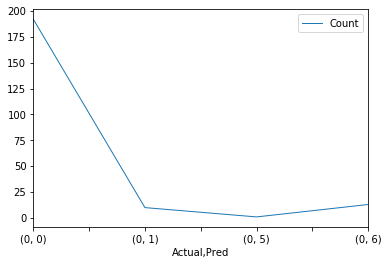

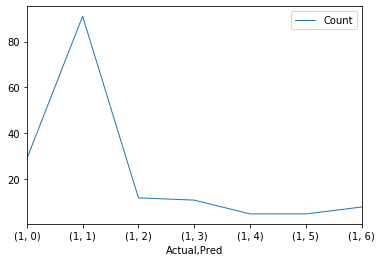

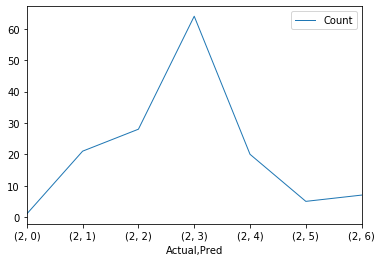

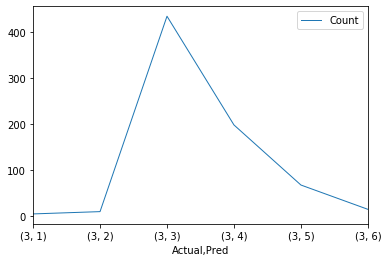

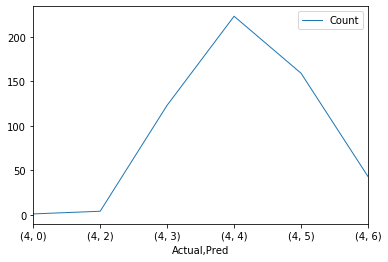

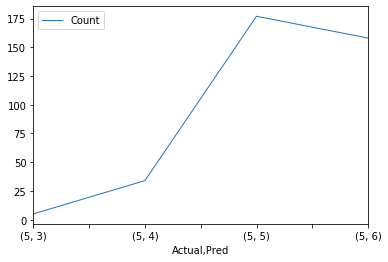

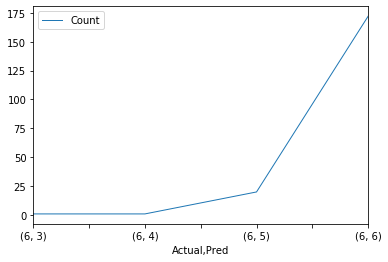

In [203]:
for age_group in set(df["Actual"]):
    df.loc[df["Actual"] == age_group].groupby(["Actual","Pred"]).count().rename(columns = {"Score":"Count"}).plot(linewidth = 1)
     

<h5>100 images which the model has falsely Predicted: </h5>

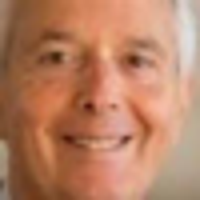

Actual: 46-64 
Pred: 65+
Score: 0.59704936


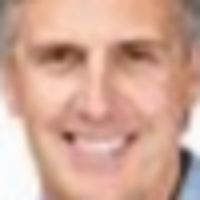

Actual: 46-64 
Pred: 31-45
Score: 0.46067044


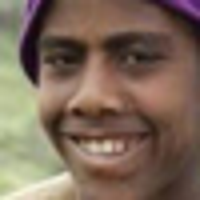

Actual: 13-20 
Pred: 31-45
Score: 0.55669785


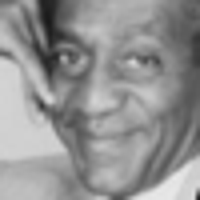

Actual: 46-64 
Pred: 65+
Score: 0.6091


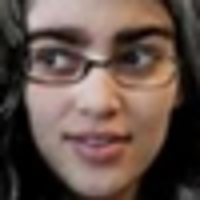

Actual: 13-20 
Pred: 21-30
Score: 0.30102256


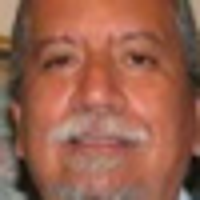

Actual: 46-64 
Pred: 65+
Score: 0.7049974


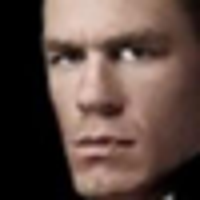

Actual: 31-45 
Pred: 21-30
Score: 0.57891756


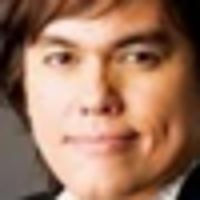

Actual: 31-45 
Pred: 46-64
Score: 0.27476254


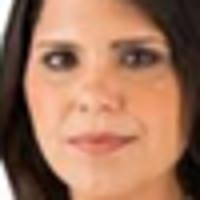

Actual: 31-45 
Pred: 46-64
Score: 0.5158573


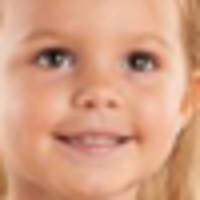

Actual: 4-12 
Pred: 0-3
Score: 0.12838022


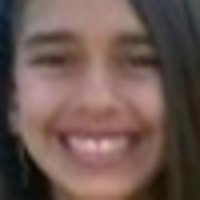

Actual: 4-12 
Pred: 13-20
Score: 0.11096546


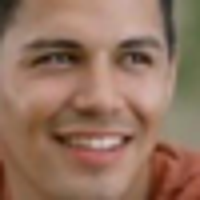

Actual: 21-30 
Pred: 31-45
Score: 0.5748762


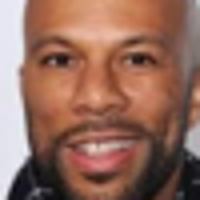

Actual: 31-45 
Pred: 46-64
Score: 0.6231365


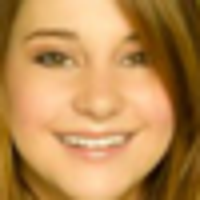

Actual: 13-20 
Pred: 46-64
Score: 0.23007202


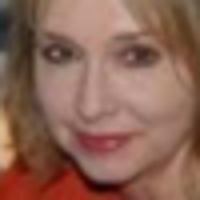

Actual: 31-45 
Pred: 46-64
Score: 0.55342156


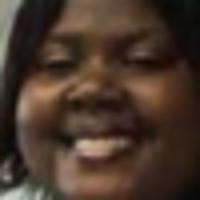

Actual: 21-30 
Pred: 31-45
Score: 0.5307885


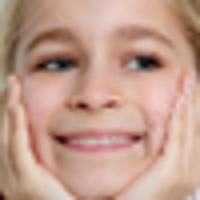

Actual: 4-12 
Pred: 65+
Score: 0.020573517


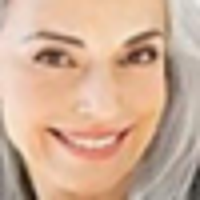

Actual: 31-45 
Pred: 46-64
Score: 0.44339707


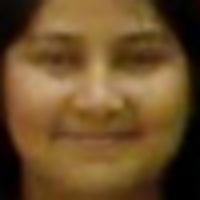

Actual: 21-30 
Pred: 31-45
Score: 0.4890736


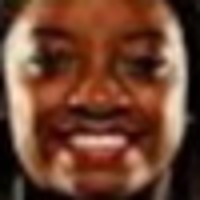

Actual: 13-20 
Pred: 31-45
Score: 0.3765637


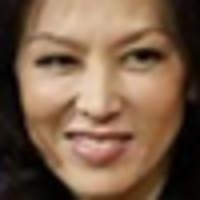

Actual: 31-45 
Pred: 21-30
Score: 0.524821


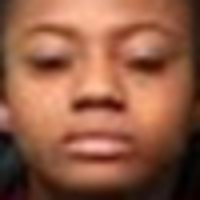

Actual: 13-20 
Pred: 21-30
Score: 0.50456434


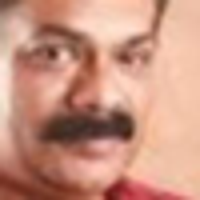

Actual: 31-45 
Pred: 46-64
Score: 0.51045597


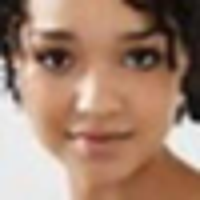

Actual: 13-20 
Pred: 21-30
Score: 0.52860814


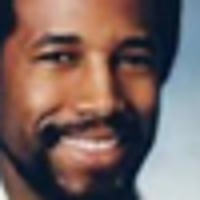

Actual: 46-64 
Pred: 21-30
Score: 0.64126056


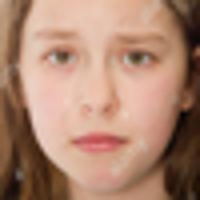

Actual: 13-20 
Pred: 4-12
Score: 0.21290053


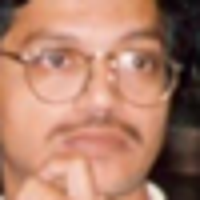

Actual: 21-30 
Pred: 46-64
Score: 0.54151434


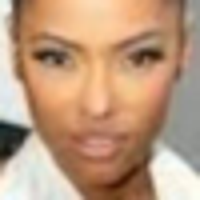

Actual: 21-30 
Pred: 31-45
Score: 0.4696569


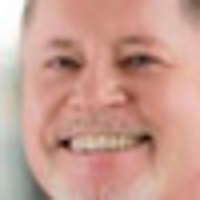

Actual: 31-45 
Pred: 65+
Score: 0.6426085


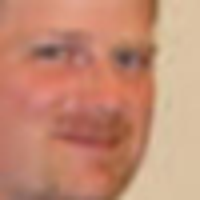

Actual: 21-30 
Pred: 46-64
Score: 0.43895668


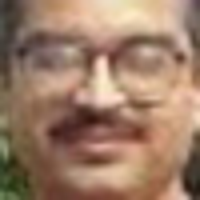

Actual: 31-45 
Pred: 46-64
Score: 0.4511219


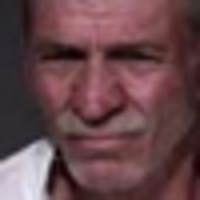

Actual: 46-64 
Pred: 65+
Score: 0.6682219


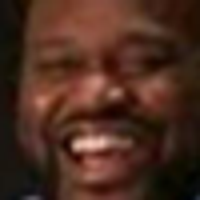

Actual: 31-45 
Pred: 46-64
Score: 0.48618832


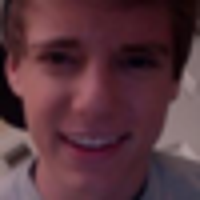

Actual: 13-20 
Pred: 31-45
Score: 0.04060562


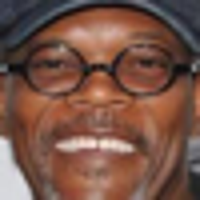

Actual: 46-64 
Pred: 65+
Score: 0.39928913


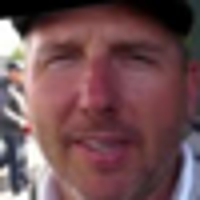

Actual: 31-45 
Pred: 46-64
Score: 0.5368396


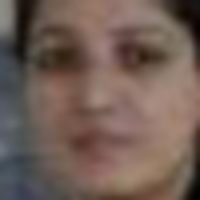

Actual: 21-30 
Pred: 31-45
Score: 0.5033846


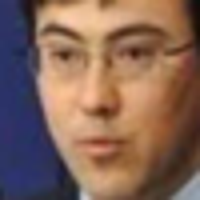

Actual: 31-45 
Pred: 46-64
Score: 0.37668428


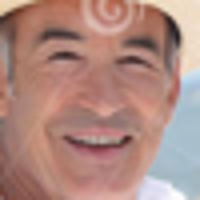

Actual: 46-64 
Pred: 65+
Score: 0.7426565


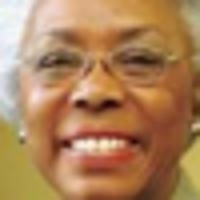

Actual: 46-64 
Pred: 65+
Score: 0.65502846


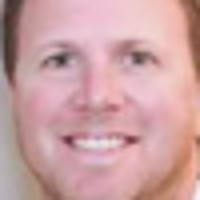

Actual: 31-45 
Pred: 46-64
Score: 0.41398174


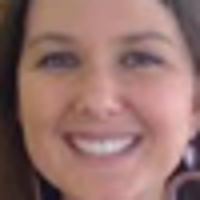

Actual: 21-30 
Pred: 31-45
Score: 0.23857093


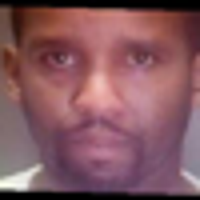

Actual: 21-30 
Pred: 31-45
Score: 0.13902757


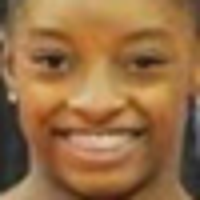

Actual: 13-20 
Pred: 46-64
Score: 0.08951389


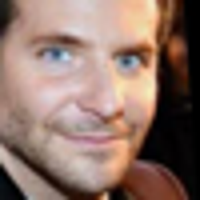

Actual: 31-45 
Pred: 46-64
Score: 0.32026926


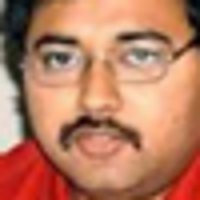

Actual: 21-30 
Pred: 31-45
Score: 0.54330456


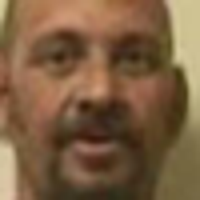

Actual: 31-45 
Pred: 46-64
Score: 0.47462535


In [205]:
i = 0
wrong_indexes = df.query("Actual != Pred").index.values

while i < 100:
    if i in wrong_indexes:
        display(Image.fromarray(X_test[i],"RGB").resize((200,200)))
        print("Actual:",age_dict[y_test[i]],"\nPred:", age_dict[pred[i]])
        print("Score:", score[i])
    i += 1

<h5> A function to predict an image outside of the dataset. </h5>

In [216]:
def predict(inp):
    if str(type(inp)) == "<class 'PIL.JpegImagePlugin.JpegImageFile'>":
        score = np.max((model.predict(np.expand_dims(np.array(inp.resize((50,50))), axis = 0))*100).round())
        group = np.argmax(model.predict(np.expand_dims(np.array(inp.resize((50,50))), axis = 0)))
        display(inp.resize((250,250)))
        print("Possible Age Group:",age_dict[group])
        print("Score:",score)
    elif str(type(inp)) ==  "<class 'list'>":  
        for elem in inp:
            score = np.max((model.predict(np.expand_dims(np.array(elem.resize((50,50))), axis = 0))*100).round())
            group = np.argmax(model.predict(np.expand_dims(np.array(elem.resize((50,50))), axis = 0)))
            display(inp.resize((250,250)))
            print("Tahmini Yaş Grubu:",age_dict[group],"\n")
            print("Score:",score)          
    else:
        print("Wrong Data Type!")

<h5> It is successful for my 1 year old nephew. </h5>

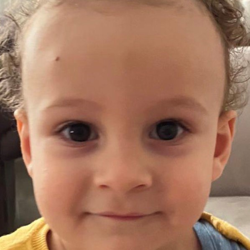

Possible Age Group: 0-3
Skor: 34.0


In [215]:
im=Image.open("atlas3.jpg")

predict(im)

<h5> But not for me :) </h5>

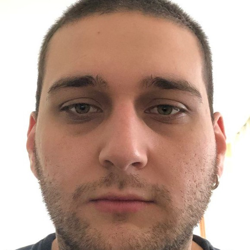

Possible Age Group: 31-45
Score: 46.0


In [218]:
im=Image.open("mert.jpg")

predict(im)